(893, 485)
[[450 209]
 [442 275]]


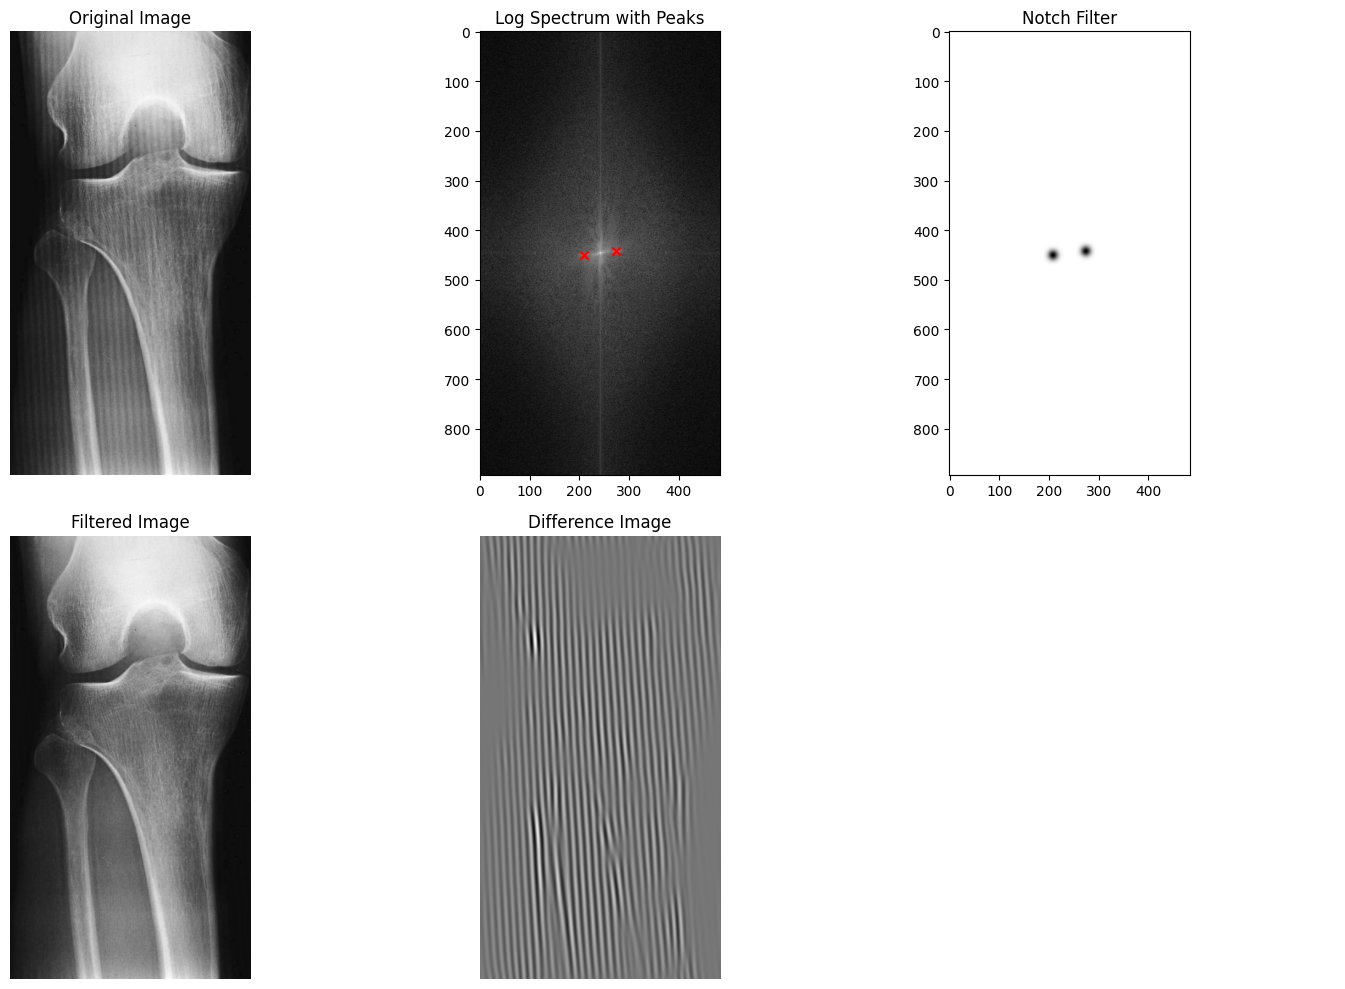

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from PIL import Image
from scipy.signal import find_peaks
import cv2
from scipy.ndimage import maximum_filter

def load_and_process_image(filename):
    """Load and convert image to grayscale float"""
    img = Image.open(filename)
    return np.array(img) / 255.0

def compute_fft_spectrum(image):
    """Compute 2D FFT and shift DC to center"""
    f_transform = fftpack.fft2(image)
    f_transform_shifted = fftpack.fftshift(f_transform)
    spectrum = np.abs(f_transform_shifted)
    return f_transform_shifted, spectrum

def find_spectrum_peaks(spectrum, threshold_rel=0.5):
    """Find peaks in the spectrum excluding the DC component"""
    # Get center coordinates
    center_y, center_x = spectrum.shape[0] // 2, spectrum.shape[1] // 2
    
    # Convert to log scale for better peak detection
    log_spectrum = np.log(spectrum + 1)
    
    # Create a mask to exclude the center region
    mask = np.ones_like(log_spectrum, dtype=bool)
    center_radius = 20
    mask[center_y-center_radius:center_y+center_radius, 
         center_x-center_radius:center_x+center_radius] = False
    
    # Find local maxima
    peaks = np.array(np.where(mask & (log_spectrum == maximum_filter(log_spectrum, size=20)))).T
    
    # Sort peaks by magnitude and get top N
    peak_values = log_spectrum[peaks[:, 0], peaks[:, 1]]
    sorted_indices = np.argsort(peak_values)[::-1]
    peaks = peaks[sorted_indices]
    
    return peaks[:2]  # Return top 4 peaks

def create_notch_filter(shape, peaks, D0):
    """
    Create notch filter following H[k,ℓ] = 1 - exp(-1/(2*D0^2)*[(k-k0)^2 + (ℓ-ℓ0)^2])
    
    Parameters:
    shape: Tuple of image dimensions (rows, cols)
    peaks: Array of peak coordinates [(y1,x1), (y2,x2), ...]
    D0: Filter parameter (width of the notch)
    """
    rows, cols = shape
    center_y, center_x = rows // 2, cols // 2
    
    # Create coordinate grids relative to center
    k, l = np.ogrid[-center_y:rows-center_y, -center_x:cols-center_x]
    
    # Initialize filter as ones
    H = np.ones((rows, cols))
    
    # Create individual notch filters for each peak
    for peak_y, peak_x in peaks:
        # Get k0, l0 as coordinates relative to center
        k0 = peak_y - center_y
        l0 = peak_x - center_x
        
        # Create notch filter according to formula
        H_notch = 1 - np.exp(-1 / (2 * D0**2) * ((k - k0)**2 + (l - l0)**2))
        
        # Create symmetric notch (for negative frequencies)
        # H_notch_symmetric = 1 - np.exp(-1 / (2 * D0**2) * ((k + k0)**2 + (l + l0)**2))
        
        # Multiply with existing filter (element-wise multiplication)
        # H = H * H_notch * H_notch_symmetric
        H = H * H_notch 
    
    return H

def apply_filter_and_inverse(f_transform, notch_filter):
    """Apply filter and compute inverse FFT"""
    filtered_spectrum = f_transform * notch_filter
    filtered_image = np.real(fftpack.ifft2(fftpack.ifftshift(filtered_spectrum)))
    return filtered_image

def plot_results(original, spectrum, peaks, notch_filter, filtered_image):
    """Plot all results in a comprehensive figure"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Log spectrum with peaks
    log_spectrum = np.log(spectrum + 1)
    axes[0, 1].imshow(log_spectrum, cmap='gray')
    axes[0, 1].scatter(peaks[:, 1], peaks[:, 0], c='r', marker='x')
    axes[0, 1].set_title('Log Spectrum with Peaks')
    # axes[0, 1].axis('off')
    
    # Notch filter
    axes[0, 2].imshow(notch_filter, cmap='gray')
    axes[0, 2].set_title('Notch Filter')

    
    # Filtered image
    axes[1, 0].imshow(filtered_image, cmap='gray')
    axes[1, 0].set_title('Filtered Image')
    axes[1, 0].axis('off')
    
    # Difference image
    difference = original - filtered_image
    axes[1, 1].imshow(difference, cmap='gray')
    axes[1, 1].set_title('Difference Image')
    axes[1, 1].axis('off')
    
    # Keep the last subplot empty or use it for additional analysis
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    return fig

# Main execution
if __name__ == "__main__":
    # Load image
    image = load_and_process_image('OPTI536_Homework_1_Images/Moire_Example.jpg')
    print(image.shape)
    # Compute FFT
    f_transform, spectrum = compute_fft_spectrum(image)
    
    # Find peaks
    peaks = find_spectrum_peaks(spectrum)
    print(peaks)
    
    # Create notch filter
    notch_filter = create_notch_filter(image.shape, peaks, D0=7)
    
    # Apply filter and get filtered image
    filtered_image = apply_filter_and_inverse(f_transform, notch_filter)
    
    # Plot results
    fig = plot_results(image, spectrum, peaks, notch_filter, filtered_image)
    plt.show()

# What do you see?  
# Subtract your result from the original image and plot the difference image.  

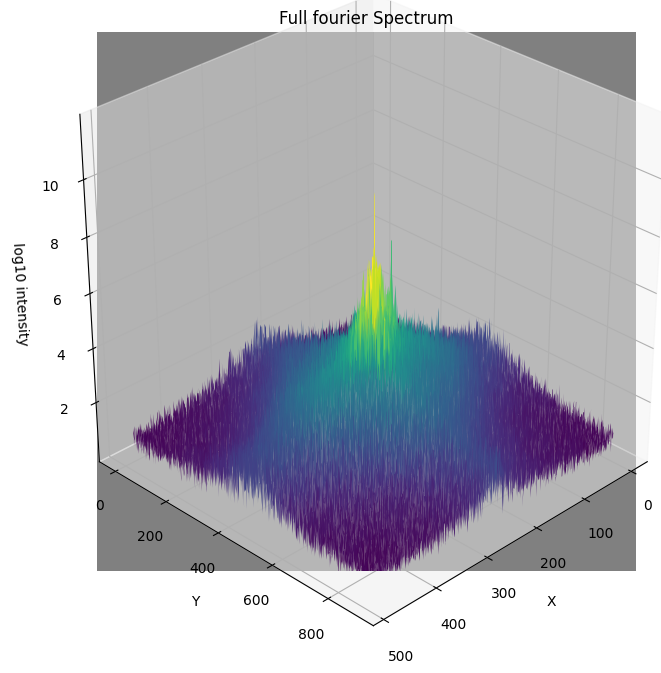

c:\Users\GanQiWen\Anaconda3\envs\AdvancedMultimedia\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


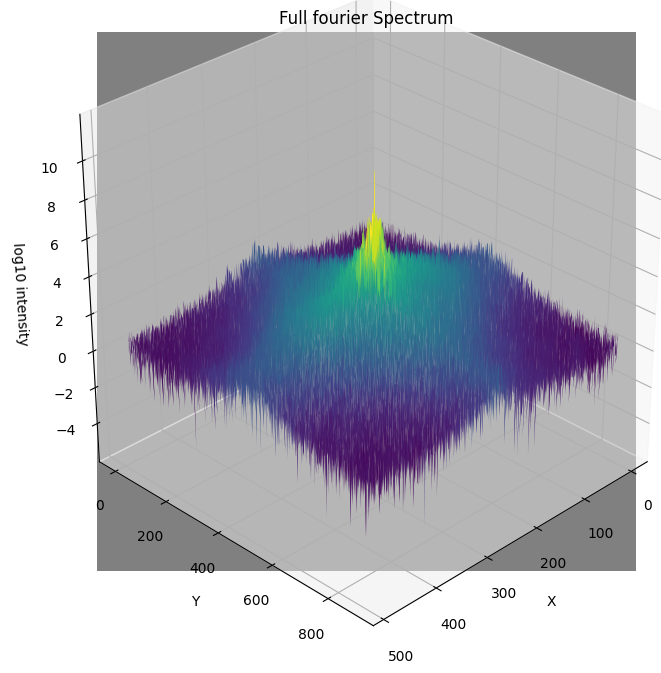

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_spectrum_peaks_3d(spectrum, peaks, window_size=20):
    """
    Create 3D visualization of spectrum peaks
    
    Parameters:
    spectrum: 2D array of the Fourier spectrum
    peaks: Array of peak coordinates [(y1,x1), (y2,x2), ...]
    window_size: Size of the window around each peak to plot
    """
    # Convert to log scale for better visualization
    log_spectrum = np.log(spectrum + 1)
    
    fig = plt.figure(figsize=(10, 7))
    # Plot full spectrum in first subplot
    ax_full = fig.add_subplot(111, projection='3d')
    Y, X = np.meshgrid(np.arange(spectrum.shape[0]), 
                      np.arange(spectrum.shape[1]), 
                      indexing='ij')
    ax_full.plot_surface(X, Y, log_spectrum, cmap='viridis')
    ax_full.set_title('Full fourier Spectrum')
    ax_full.view_init(elev=30, azim=45)  # Change angles for better visibility
    ax_full.set_xlabel('X')
    ax_full.set_ylabel('Y')
    ax_full.set_zlabel('log10 intensity')

    # **Zoom in by adjusting limits**
    # ax_full.set_xlim(-1, 1)  # Crop X range
    # ax_full.set_ylim(-1, 1)  # Crop Y range
    # ax_full.set_zlim(-0.5, 1)  # Adjust Z range

    # **Change camera distance (lower = closer)**
    ax_full.dist = 8  # Default is ~10, lower values zoom in

    # **Maintain aspect ratio for better zoom effect**
    ax_full.set_box_aspect([1, 1, 1])  # Adjust aspect ratio
    ax_full.set_facecolor('grey')

    return fig

# Example usage
if __name__ == "__main__":
    # Assuming you have already computed the spectrum and found peaks
    # from your previous code
    image = load_and_process_image('OPTI536_Homework_1_Images/Moire_Example.jpg')
    f_transform, spectrum = compute_fft_spectrum(image)
    peaks = find_spectrum_peaks(spectrum)
    
    # Create 3D visualization
    fig = plot_spectrum_peaks_3d(spectrum, peaks)
    plt.show()

    filtered_spectrum = f_transform * notch_filter
    fig2 = plot_spectrum_peaks_3d(filtered_spectrum, peaks)
    plt.show()

In [97]:
# todo, compare different d0 vlaue eg, 1,5,10,15,20 
def compare_different_d0_value(image, peaks, f_transform, d0_values):
    results = {}
    
    for D0 in d0_values:
        # Apply custom bilateral filter
        # Create notch filter
        notch_filter = create_notch_filter(image.shape, peaks, D0=D0)
        
        # Apply filter and get filtered image
        filtered_image = apply_filter_and_inverse(f_transform, notch_filter)
        
        # For comparison with MATLAB's imbilatfilt
        title = f'notch_filter (D0={D0})'
        results[title] = filtered_image
    
    return results

def plot_D0s_results(image, filtered_results):
    """
    Plot bilateral filter results with custom filters in row 1 and skimage filters in row 2
    
    Parameters:
    image: Original input image
    filtered_results: Dictionary of filtered images with parameter descriptions
    """
    fig, axes = plt.subplots(1, 6, figsize=(20, 8))
    
    # Plot original image in both rows
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    

    
    # Plot custom results in first row
    for idx, (title, img) in enumerate(filtered_results.items()):
        axes[idx + 1].imshow(img, cmap='gray')
        axes[idx + 1].set_title(title)
        axes[idx + 1].axis('off')
    
    plt.tight_layout()
    return fig


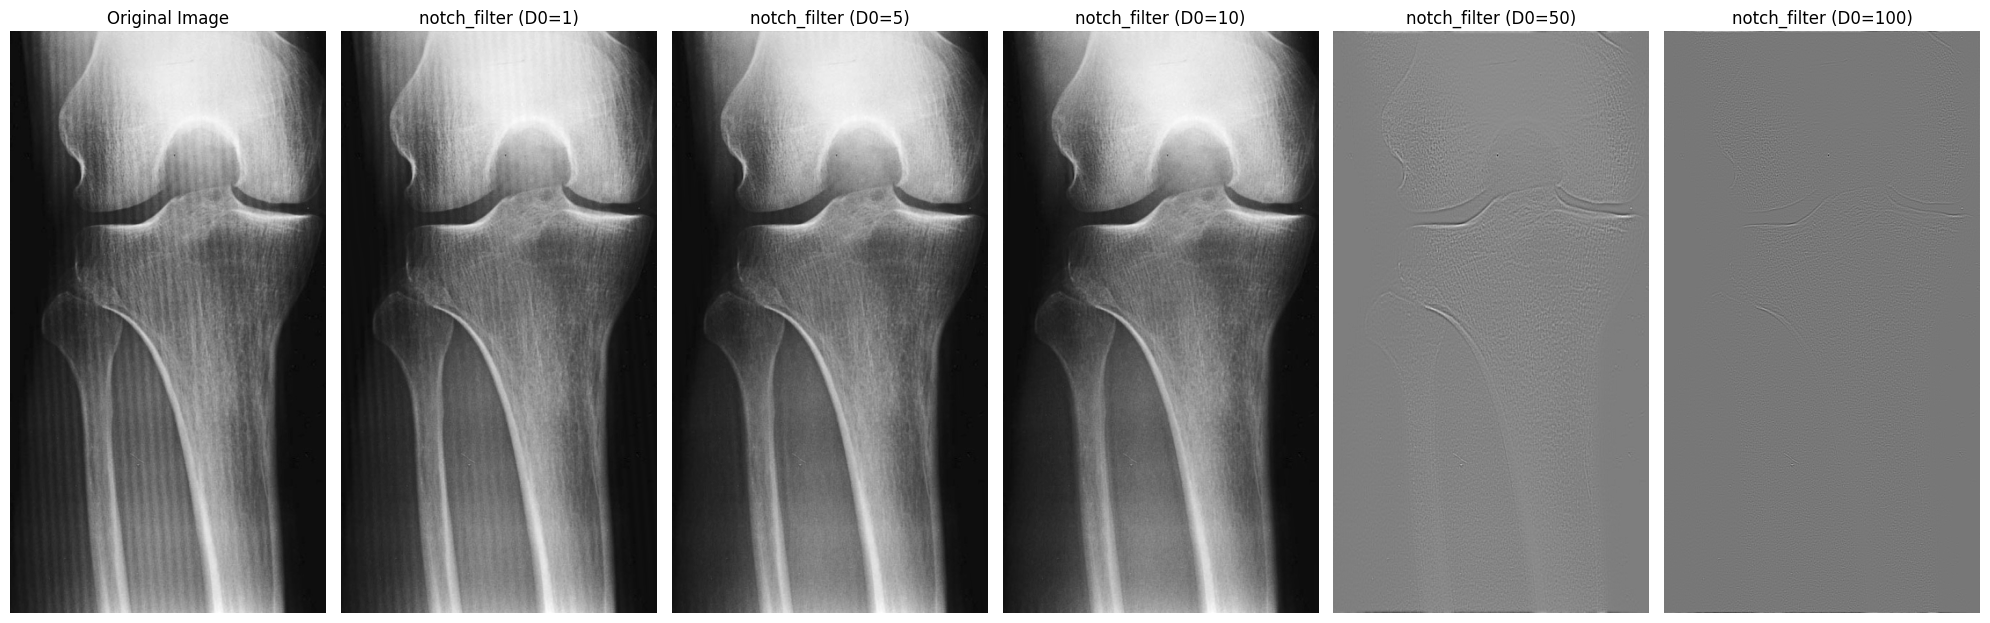

In [105]:
d0_values = [1,5,10,50,100]
results= compare_different_d0_value(image,peaks,f_transform,d0_values)
plot_D0s_results(image,results)
plt.show()

In [106]:
# compare different location peak / shift around your notch filter in fourier space and plot the results
# todo, compare different d0 vlaue eg, 1,5,10,15,20 
def compare_different_peak_location(image, peaks, f_transform, d0, y_shift, x_shift):
    results = {}
    
    for x_offset in x_shift:
        for y_offset in y_shift:
            # Create notch filter
            offset = np.array([y_offset, x_offset])  # Replace dx, dy with your desired offset values
            offseted_peaks = peaks + offset
            print(f'{peaks} -> {offseted_peaks}')
            notch_filter = create_notch_filter(image.shape, offseted_peaks, D0=d0)
            
            # Apply filter and get filtered image
            filtered_image = apply_filter_and_inverse(f_transform, notch_filter)
            
            # For comparison with MATLAB's imbilatfilt
            title = f'offseted_notch_filter (dx={x_offset}, dy={y_offset}))'
            results[title] = filtered_image
            notch_title = f'offseted_notch_filter location {offseted_peaks}))'
            results[notch_title] = notch_filter
    
    return results


def plot_offsets_results(filtered_results):
    """
    Plot bilateral filter results with custom filters in row 1 and skimage filters in row 2.
    
    Parameters:
    filtered_results: Dictionary of filtered images with parameter descriptions.
    """
    fig, axes = plt.subplots(3, 6, figsize=(12, 12))  # Adjust size for better visibility
    axes = axes.ravel()  # Flatten 3x3 grid into a 1D array for easy iteration

    for idx, (title, img) in enumerate(filtered_results.items()):
        if idx >= 18:  # Prevent overflow if more than 9 images
            break
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(title, fontsize=10)
        # axes[idx].axis('off')

    plt.tight_layout()
    return fig


[[450 209]
 [442 275]] -> [[451 210]
 [443 276]]
[[450 209]
 [442 275]] -> [[460 210]
 [452 276]]
[[450 209]
 [442 275]] -> [[500 210]
 [492 276]]
[[450 209]
 [442 275]] -> [[451 219]
 [443 285]]
[[450 209]
 [442 275]] -> [[460 219]
 [452 285]]
[[450 209]
 [442 275]] -> [[500 219]
 [492 285]]
[[450 209]
 [442 275]] -> [[451 259]
 [443 325]]
[[450 209]
 [442 275]] -> [[460 259]
 [452 325]]
[[450 209]
 [442 275]] -> [[500 259]
 [492 325]]


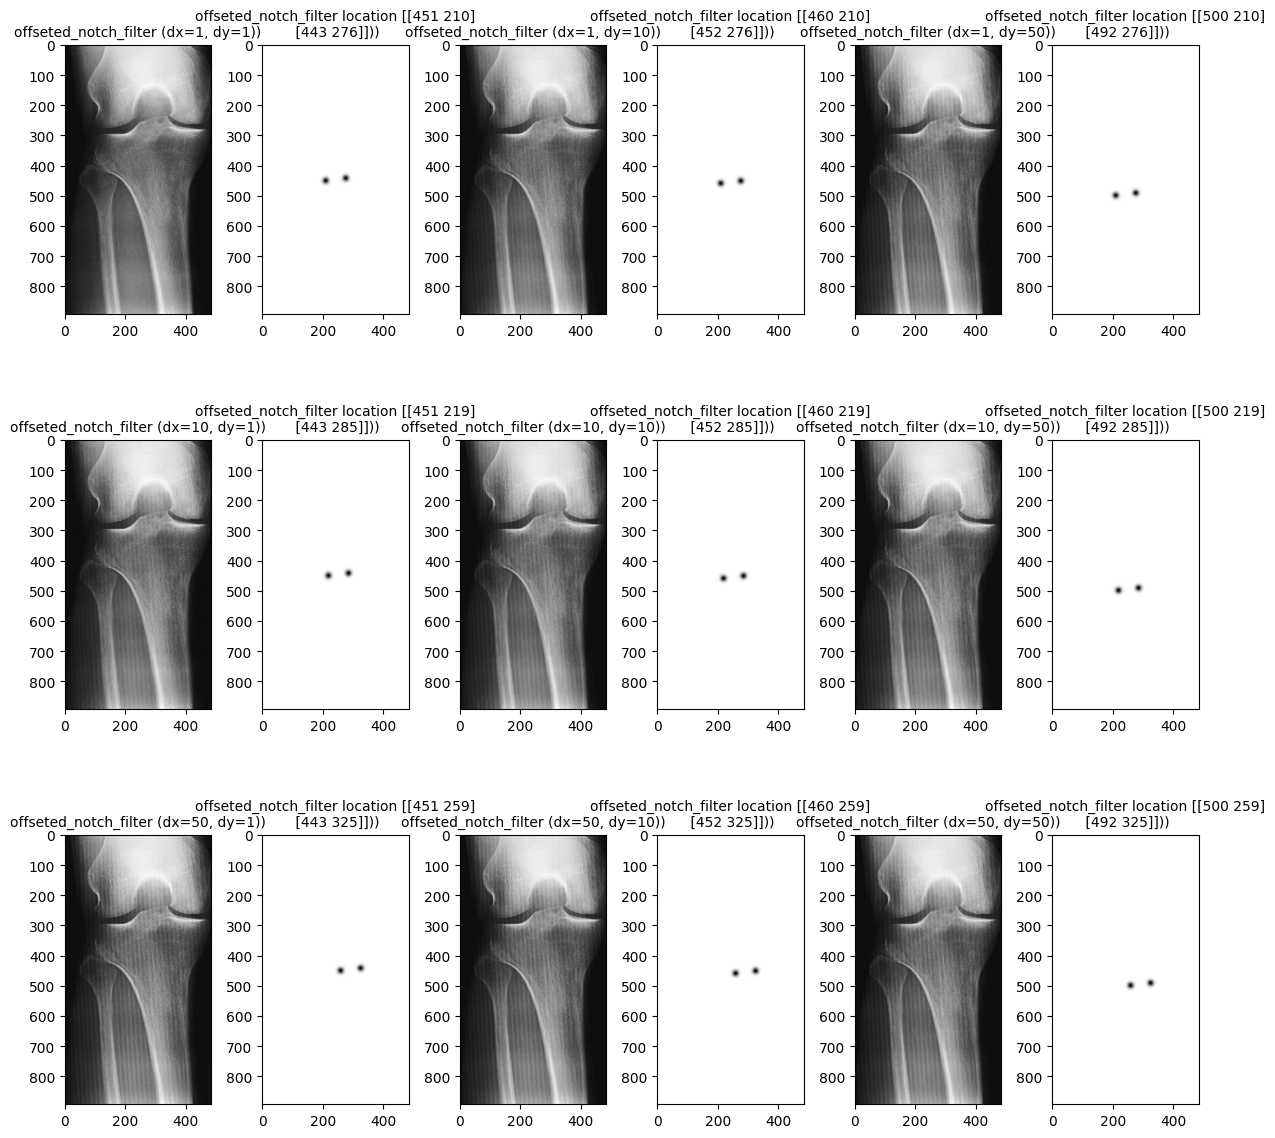

In [107]:
y_shift = [1,10,50]
x_shift = [1,10,50]

results_2= compare_different_peak_location(image,peaks,f_transform, 7, y_shift, x_shift)
plot_offsets_results(results_2)
plt.show()